# Building Skin cancer classification using transfer learning 
# (Inception V3)

## Article reference

- https://www.nature.com/articles/nature21056.epdf?author_access_token=8oxIcYWf5UNrNpHsUHd2StRgN0jAjWel9jnR3ZoTv0NXpMHRAJy8Qn10ys2O4tuPakXos4UhQAFZ750CsBNMMsISFHIKinKDMKjShCpHIlYPYUHhNzkn6pSnOCt0Ftf6&fbclid=IwAR3ySc4WozYU5qyZ6wU43PIzv2JioHtyHBnnr79fLagdP74sp7BOf_j-ynw


In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import os
from glob import glob
from PIL import Image
import itertools
import time

from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras import backend as K
from keras.layers.normalization import BatchNormalization

from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

from keras.preprocessing import image

# Import google inception v3 as pre-trained model for transfer learning
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input

# Keras layer utilities
from keras.layers import GlobalAveragePooling2D, Dense, Dropout,Flatten, Conv2D
from keras.layers import Input
from keras.models import Model
from keras import optimizers
from keras.regularizers import l2

from keras.callbacks import TensorBoard
from keras.models import load_model

import warnings
warnings.filterwarnings('ignore')

from sklearn import metrics 
np.random.seed(123)

C:\Users\Admin\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14519677774397083402
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1500636774
locality {
  bus_id: 1
}
incarnation: 15656117348654121559
physical_device_desc: "device: 0, name: GeForce 940MX, pci bus id: 0000:01:00.0, compute capability: 5.0"
]


##### Data preparation

In [4]:
base_skin_dir = r'.input'

# Merging images from both folders HAM10000_images_part1.zip and HAM10000_images_part2.zip into one dictionary

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

base_skin_dir = os.path.join('input')

# This dictionary is useful for displaying more human-friendly labels later on

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}


skin_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))

# Creating New Columns for better readability

skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes
skin_df.head()



,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,None,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,None,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,None,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,None,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,None,Benign keratosis-like lesions,2


In [5]:
# Step 4 : Data Cleaning
# In this step we check for Missing values and datatype of each field
skin_df.isnull().sum()


lesion_id            0
image_id             0
dx                   0
dx_type              0
age                 57
sex                  0
localization         0
path             10015
cell_type            0
cell_type_idx        0
dtype: int64

In [7]:
# As it is evident from the above that only age has null values which is 57 so we will fill the null values by their mean.
skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)

skin_df.isnull().sum()


lesion_id            0
image_id             0
dx                   0
dx_type              0
age                  0
sex                  0
localization         0
path             10015
cell_type            0
cell_type_idx        0
dtype: int64

In [8]:
#skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((299,299))))

features=skin_df.drop('cell_type_idx',axis=1)
target=skin_df['cell_type_idx']

In [5]:
# Train test split
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(
        features, target, test_size=0.20,random_state=1234)

##### Split images for usage in flow_from_directory 

In [10]:
# Split images for usage in flow_from_directory 
import shutil
from time import time

def images_mover(base_path, classes_list, images_path, images_class):
    ''' create directories for the usage of keras flow_from_directory
    Args
    ====
    base_path : 
    classes_list : (list) classes of current training data, folders will be created for each classes
    images_path : (series) series that contains the path of all images
    images_class : (series) series that contains the corresponding class for each images in images_path
    
    Returns
    =======
    None
    
    '''
    for cl in classes_list:
        os.mkdir(f'{base_path}/{cl}')
    
    t = time()
    for idx,file in enumerate(images_path):
        #print(file)
        cl = images_class.iloc[idx]
        new_dir = f'{base_path}/{cl}'
        shutil.copy(file, new_dir)
        #print(file+" move to "+ new_dir)
        
    print("Done with moving in %fs"%(time()-t))

os.mkdir('input/training')
os.mkdir('input/testing')

images_mover(base_path='input/training', classes_list=skin_df['cell_type_idx'].unique(),
             images_path=x_train_o['path'], images_class=y_train_o)

Done with moving in 104.954081s


In [11]:
images_mover(base_path='input/testing', classes_list=skin_df['cell_type_idx'].unique(),
             images_path=x_test_o['path'], images_class=y_test_o)

Done with moving in 26.417501s


## EDA

In [13]:
skin_df.groupby('cell_type_idx').agg({"path":'count'})

,path
cell_type_idx,
0,327
1,514
2,1099
3,115
4,6705
5,1113
6,142


4th class have the most examples

In [14]:
skin_df.shape

(10015, 10)

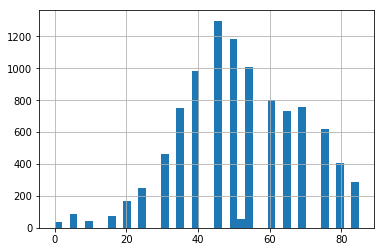

In [11]:
skin_df['age'].hist(bins=40)

=> Larger instances of patients having age from 30 to 60.

## Building keras model

In [2]:
''' 
Image Augmentation --> instantiate generators of augmented image batches

I followed the pre-processing technique from nature article, i.e. random rotation and random vertical flip.
''' 

# image augmentation for training set
train_datagen = image.ImageDataGenerator(rescale=1./255,
                                         rotation_range = 359,
                                         vertical_flip=True) # randomly flip images

# image augmentation for training set
test_datagen = image.ImageDataGenerator(rescale=1./255)

In [3]:
training_batch_size = 8
validation_batch_size = 8

train_generator = train_datagen.flow_from_directory(
        r'input\training',
        target_size = (299, 299),
        batch_size = training_batch_size,
        class_mode = 'categorical')

validation_generator = test_datagen.flow_from_directory(
        r'input\testing',
        target_size = (299, 299),
        batch_size = validation_batch_size,
        class_mode = 'categorical')

Found 8012 images belonging to 7 classes.
Found 2003 images belonging to 7 classes.


In [10]:
#''' We use ADAM with epsilon set to 0.1 '''
## epsilon for Inception network on ImageNet can be tuned to either 1 or 0.1 
## suggested by: https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/
#adam = optimizers.Adam(epsilon = 0.1) 

'''
Why SGD?:
    1. Fine tune in a very slow learning rate
    2. This is to make sure that the magnitude of the updates stays very small, 
       so as not to wreck the previously learned features
    
Links:
------
    https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
    http://ruder.io/optimizing-gradient-descent/index.html#rmsprop
    ADAM = RMSProp + momentum. https://www.dlology.com/blog/quick-notes-on-how-to-choose-optimizer-in-keras/
'''
adam = optimizers.Adam(lr=0.001, epsilon = 0.1, decay=0.9) 

rmsprop = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=0.1, decay=0.9)
#optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=0.1, decay=0.9)
#optimizers.Adam(lr=0.001, epsilon = 0.1, decay=0.9) 

In [13]:
# Custom mertrics to calculate f1-score, recall, and precision after each epoch
class Metrics(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []  
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self, epoch, logs={}):
        test_steps_per_epoch = np.math.ceil(validation_generator.samples / validation_generator.batch_size)
        predictions = self.model.predict_generator(validation_generator, steps=test_steps_per_epoch)
        # Get most likely class
        predicted_classes = np.argmax(predictions, axis=1)
        true_classes = validation_generator.classes
        class_labels = list(validation_generator.class_indices.keys())   
        precisions, recall, f1_score, _ = metrics.precision_recall_fscore_support(
                                            true_classes, predicted_classes)
        _val_f1 = np.mean(f1_score)
        _val_recall = np.mean(recall)
        _val_precision = np.mean(precisions)
        
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        
        print("— val_f1: %f — val_precision: %f — val_recall %f" %(_val_f1, _val_precision, _val_recall))
        return


metric = Metrics()

In [57]:
''' 
    References:
    
    - https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
    - https://medium.com/@thongonary/how-to-compute-f1-score-for-each-epoch-in-keras-a1acd17715a2?fbclid=IwAR1rg9o6Q2fW40fdyhu4Xu9Dp_C6aNIKy3yT-cf4wb35B-gT8P607s5-Qkw
    - https://keras.io/applications/?fbclid=IwAR07i9klCgeBoICY_w5mIP7MRxyXviwUi_rzFNo4nvnC5pLez8zzK-c_SpI
'''

base_model = InceptionV3(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
out = Dense(7, activation='softmax')(x)



''' Freeze all the layers (except output layer) of the base model '''
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    # By default, layer.trainable = True (we must set to False to freeze the weights)
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
# reference: https://stackoverflow.com/questions/43547402/how-to-calculate-f1-macro-in-keras
custom_v3_model = Model(inputs = base_model.input, outputs = out)
#custom_v3_model.summary()

custom_v3_model.compile(loss = 'categorical_crossentropy',
                        optimizer = 'rmsprop', 
                        metrics = ['accuracy'])
start = time.time()
class_weight = compute_class_weight('balanced',np.unique(train_generator.classes),train_generator.classes)
hist_1 = custom_v3_model.fit_generator(
            train_generator,
            # use floor devision to get integer for the final value
            steps_per_epoch = train_generator.samples // training_batch_size,
            epochs = 5,
            validation_data = validation_generator,
            validation_steps = validation_generator.samples // validation_batch_size,
            class_weight=class_weight,
            callbacks=[metric])


Epoch 1/5
1001/1001 [==============================] - 577s 577ms/step - loss: 0.9880 - acc: 0.6725 - val_loss: 1.5246 - val_acc: 0.6590
— val_f1: 0.114527 — val_precision: 0.110131 — val_recall 0.142897
Epoch 2/5
1001/1001 [==============================] - 1254s 1s/step - loss: 0.9035 - acc: 0.6919 - val_loss: 2.0071 - val_acc: 0.6596
— val_f1: 0.115231 — val_precision: 0.113135 — val_recall 0.142720
Epoch 3/5
1001/1001 [==============================] - 2481s 2s/step - loss: 0.8745 - acc: 0.6983 - val_loss: 1.8769 - val_acc: 0.6612
— val_f1: 0.114563 — val_precision: 0.237116 — val_recall 0.142897
Epoch 4/5
1001/1001 [==============================] - 1514s 2s/step - loss: 0.8510 - acc: 0.7033 - val_loss: 2.1138 - val_acc: 0.6617
— val_f1: 0.113268 — val_precision: 0.094162 — val_recall 0.142100
Epoch 5/5
1001/1001 [==============================] - 2358s 2s/step - loss: 0.8401 - acc: 0.7119 - val_loss: 1.9019 - val_acc: 0.6612
— val_f1: 0.117994 — val_precision: 0.122698 — val_reca

In [58]:
'''
--> Save the model (trained output layers) into a single HDF5 file
---> Load this pre-trained model next time before going to the steps below!!!
'''

custom_v3_model.save(r'model\model_first_5_epo.h5')


In [5]:
custom_v3_model = load_model(r'model\model_first_5_epo.h5')

In [6]:
'''
Now, the top layers are well trained. We will freeze the bottom N layers and 
train the remaining top layers
'''

base_model = InceptionV3(weights='imagenet', include_top=False)

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

0 input_1
1 conv2d_1
2 batch_normalization_1
3 activation_1
4 conv2d_2
5 batch_normalization_2
6 activation_2
7 conv2d_3
8 batch_normalization_3
9 activation_3
10 max_pooling2d_1
11 conv2d_4
12 batch_normalization_4
13 activation_4
14 conv2d_5
15 batch_normalization_5
16 activation_5
17 max_pooling2d_2
18 conv2d_9
19 batch_normalization_9
20 activation_9
21 conv2d_7
22 conv2d_10
23 batch_normalization_7
24 batch_normalization_10
25 activation_7
26 activation_10
27 average_pooling2d_1
28 conv2d_6
29 conv2d_8
30 conv2d_11
31 conv2d_12
32 batch_normalization_6
33 batch_normalization_8
34 batch_normalization_11
35 batch_normalization_12
36 activation_6
37 activation_8
38 activation_11
39 activation_12
40 mixed0
41 conv2d_16
42 batch_normalization_16
43 activation_16
44 conv2d_14
45 conv2d_17
46 batch_normalization_14
47 batch_normalization_17
48 activation_14
49 activation_17
50 average_pooling2d_2
51 conv2d_13
52 conv2d_15
53 conv2d_18
54 conv2d_19
55 batch_normalization_13
56 batch_norma

In [7]:
'''
We chose to train the top 2 inception blocks, i.e. we will freeze the first 
249 layers and unfreeze the rest:
'''

for layer in custom_v3_model.layers[:249]:  # freeze the first 249 layers
    layer.trainable = False
for layer in custom_v3_model.layers[249:]:  # unfreeze the rest of the layers
    layer.trainable = True

In [11]:
'''
We need to recompile the custom_v3_model for these modifications to take effect
'''
custom_v3_model.compile(loss = 'categorical_crossentropy',
                        optimizer = rmsprop,
                        metrics = ['accuracy'])

In [12]:
# Build a tensorflow instant for callback
tensorboard = TensorBoard(log_dir=r'log\{}'.format(str(time.time())),
                          batch_size = 8)  # batch size same as training and validation images


In [14]:
'''
We train our model again (this time fine-tuning the top 2 inception blocks
alongside the top Dense layers
'''

start = time.time()
hist = custom_v3_model.fit_generator(
        train_generator,
        steps_per_epoch = train_generator.samples / training_batch_size,
        epochs = 5,
        validation_data = validation_generator,
        validation_steps = validation_generator.samples / validation_batch_size,
        callbacks = [metric, tensorboard]) 
end = time.time()

# check execution time to run V3 model fitting
print('\nTime taken to fit InceptionV3 model with training data: {} mins\n'.format((end - start)/60))  

Epoch 1/5
1002/1001 [==============================] - 1414s 1s/step - loss: 0.7607 - acc: 0.7339 - val_loss: 1.7643 - val_acc: 0.6670
— val_f1: 0.114161 — val_precision: 0.104130 — val_recall 0.141057
Epoch 2/5
1002/1001 [==============================] - 1133s 1s/step - loss: 0.7537 - acc: 0.7353 - val_loss: 1.7496 - val_acc: 0.6675
— val_f1: 0.114733 — val_precision: 0.113217 — val_recall 0.140988
Epoch 3/5
1002/1001 [==============================] - 1496s 1s/step - loss: 0.7609 - acc: 0.7345 - val_loss: 1.7560 - val_acc: 0.6660
— val_f1: 0.113900 — val_precision: 0.103912 — val_recall 0.140732
Epoch 4/5
1002/1001 [==============================] - 1228s 1s/step - loss: 0.7489 - acc: 0.7322 - val_loss: 1.7701 - val_acc: 0.6665
— val_f1: 0.112596 — val_precision: 0.094194 — val_recall 0.139935
Epoch 5/5
1002/1001 [==============================] - 1725s 2s/step - loss: 0.7434 - acc: 0.7368 - val_loss: 1.7688 - val_acc: 0.6660
— val_f1: 0.113434 — val_precision: 0.104179 — val_recall

In [15]:
'''
Evaluates the model on a data generator
gives out a measure of performance
'''

(loss, accuracy) = custom_v3_model.evaluate_generator(validation_generator, 
                                                      steps = validation_generator.samples // validation_batch_size)

print("[INFO] loss={:.5f}, accuracy: {:.5f}%".format(loss,accuracy * 100))


[INFO] loss=1.76182, accuracy: 66.65000%


In [16]:
# save the model into a single HDF5 file
custom_v3_model.save(r'model\model_5_5.h5')

In [17]:
'''
We train our model again (this time fine-tuning the top 2 inception blocks
alongside the top Dense layers
'''
start = time.time()
hist = custom_v3_model.fit_generator(
        train_generator,
        steps_per_epoch = train_generator.samples / training_batch_size,
        epochs = 5,
        validation_data = validation_generator,
        validation_steps = validation_generator.samples / validation_batch_size,
        callbacks = [metric, tensorboard]) 
end = time.time()

# check execution time to run V3 model fitting
print('\nTime taken to fit InceptionV3 model with training data: {} mins\n'.format((end - start)/60)) 

Epoch 1/5
1002/1001 [==============================] - 1190s 1s/step - loss: 0.7488 - acc: 0.7298 - val_loss: 1.7637 - val_acc: 0.6665
— val_f1: 0.115859 — val_precision: 0.124758 — val_recall 0.141677
Epoch 2/5
1002/1001 [==============================] - 1721s 2s/step - loss: 0.7409 - acc: 0.7359 - val_loss: 1.7605 - val_acc: 0.6650
— val_f1: 0.123920 — val_precision: 0.203985 — val_recall 0.146877
Epoch 3/5
1002/1001 [==============================] - 2160s 2s/step - loss: 0.7457 - acc: 0.7368 - val_loss: 1.7622 - val_acc: 0.6685
— val_f1: 0.123320 — val_precision: 0.142397 — val_recall 0.146279
Epoch 4/5
1002/1001 [==============================] - 2451s 2s/step - loss: 0.7494 - acc: 0.7352 - val_loss: 1.7901 - val_acc: 0.6620
— val_f1: 0.115632 — val_precision: 0.124588 — val_recall 0.141353
Epoch 5/5
1002/1001 [==============================] - 5943s 6s/step - loss: 0.7343 - acc: 0.7381 - val_loss: 1.7698 - val_acc: 0.6650
— val_f1: 0.115849 — val_precision: 0.121003 — val_recall

It looks like validation accuracy and training accuracy has yet to converge.

In [18]:
custom_v3_model.save(r'model\model_5_10.h5')

## Evaluation on the model

In [4]:
model = load_model(r'model\model_5_10.h5')

In [5]:
# Evaluate model by data generator
(loss, accuracy) = model.evaluate_generator(validation_generator)

In [6]:
# Get predicted and true classes.
predictions = model.predict_generator(validation_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = validation_generator.classes

In [7]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    #plt.xticks(tick_marks, classes, rotation=45) # Do not show class name in x-axis
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


Confusion matrix, without normalization
[[   0    0    0    0   59    1    0]
 [   0    0    0    0   96    0    1]
 [   0    0    0    6  215    2    1]
 [   0    0    0    1   25    1    0]
 [   1    0    2    7 1294   10    6]
 [   0    0    0    2  241    2    1]
 [   0    0    0    0   29    0    0]]


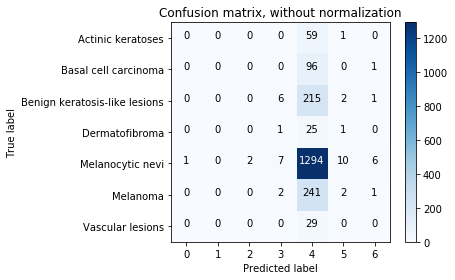

In [8]:
# Refer this link: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
confusion_mat = confusion_matrix(true_classes, predicted_classes)

# Plot non-normalized confusion matrix
plt.figure()

plot_confusion_matrix(confusion_mat, 
                      classes=['Actinic keratoses','Basal cell carcinoma','Benign keratosis-like lesions',
                                'Dermatofibroma','Melanocytic nevi','Melanoma', 'Vascular lesions'],
                      title='Confusion matrix, without normalization')

plt.show()


=> Observed that 3 classes (**Actinic keratoses**,**Basal cell carcinoma**,**Benign keratosis-like lesions**) do not have any correct prediction. Which can actually being explained by low **f1-score (0.115849)**.